# Big Data Management Project 4:
## Airline Delay and Cancellation Prediction with Spark ML


### Imports & Setup

### 1. Data Ingestion and Preparation

In [16]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("BDM_Project4") \
    .getOrCreate()

In [80]:
df2009 = (spark.read
      .option("header", "true")
      .option("inferSchema", "true")
      .csv("input/2009.csv"))  
df2009.printSchema()
df2009.show(5)

root
 |-- FL_DATE: date (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- ACTUAL_ELAPSED_TIME: double (nullable = true)
 |-- AIR_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CARRIER_DELAY: double (nullable = true)
 |-- WEATHER_DELAY: doub

#### Save as parquet, partitioned by extracted month

In [81]:
from pyspark.sql.functions import col, month, dayofweek

df2009 = df2009.withColumn("Month", month(col("FL_DATE")))
df2009 = df2009.withColumn("DayOfWeek", dayofweek(col("FL_DATE")))
df2009.write.mode("overwrite").partitionBy("Month").parquet("/home/jovyan/input/2009_parquet/")

### 2. Cleaning and Preprocessing 

In [84]:
df2009 = df2009.drop("Unnamed: 27")

df2009 = df2009.withColumnRenamed("OP_CARRIER", "UniqueCarrier") 
df2009 = df2009.withColumnRenamed("OP_CARRIER_FL_NUM", "UniqueCarrierFlightNumber") 

df2009_cleaned = df2009.dropna(subset=['FL_DATE', 'UniqueCarrier'])

df2009_cleaned = df2009_cleaned.filter(col("DIVERTED") == 0.0)

df2009_cleaned = df2009_cleaned.withColumn("Month", month("FL_DATE")) \
                                 .withColumn("DayOfWeek", dayofweek("FL_DATE"))

### 3. Exploratory Analysis 

In [86]:
cancelled = df2009_cleaned.filter(df2009_cleaned["CANCELLED"] == 1.0)
cancelled.count()

87038

In [87]:
# Top 10 carriers by number of flights
top_10_carriers = cancelled.groupBy("UniqueCarrier").count().orderBy("count", ascending=False).limit(10)
top_10_carriers.show()

+-------------+-----+
|UniqueCarrier|count|
+-------------+-----+
|           MQ|10695|
|           AA| 9191|
|           WN| 8405|
|           OO| 7423|
|           EV| 6314|
|           UA| 6213|
|           XE| 5193|
|           OH| 5108|
|           US| 5047|
|           DL| 4799|
+-------------+-----+



In [88]:
# Count cancellation reasons
cancel_reasons = cancelled.groupBy("CANCELLATION_CODE").count().orderBy("count", ascending=False)
cancel_reasons.show()

+-----------------+-----+
|CANCELLATION_CODE|count|
+-----------------+-----+
|                B|36651|
|                A|35568|
|                C|14799|
|                D|   20|
+-----------------+-----+



From Kaggle:
Reason for Cancellation of flight: 
A - Airline/Carrier; 
B - Weather; 
C - National Air System; 
D - Security

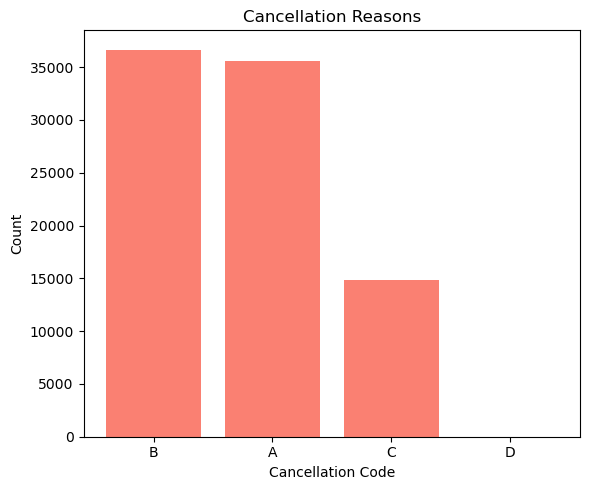

In [89]:
import matplotlib.pyplot as plt
cancel_reasons_pd = cancel_reasons.toPandas()

plt.figure(figsize=(6,5))
plt.bar(cancel_reasons_pd["CANCELLATION_CODE"], cancel_reasons_pd["count"], color='salmon')
plt.xlabel("Cancellation Code")
plt.ylabel("Count")
plt.title("Cancellation Reasons")
plt.tight_layout()
plt.show()

In [90]:
from pyspark.sql.functions import concat_ws

df2009_cleaned.withColumn("Route", concat_ws("->", "ORIGIN", "DEST")) \
               .groupBy("Route").count().orderBy("count", ascending=False).show(10)

+--------+-----+
|   Route|count|
+--------+-----+
|OGG->HNL|13328|
|HNL->OGG|12963|
|SFO->LAX|12132|
|LAX->SFO|12122|
|SAN->LAX|11020|
|LAX->SAN|11012|
|BOS->LGA|10870|
|LGA->BOS|10866|
|LAX->LAS|10682|
|LAS->LAX|10659|
+--------+-----+
only showing top 10 rows



In [91]:
class_dist = df2009_cleaned.groupBy("CANCELLED").count()
class_dist.show()

counts = class_dist.collect()
class_counts = {row['CANCELLED']: row['count'] for row in counts}

imbalance_ratio = max(class_counts.values()) / min(class_counts.values())
print(f"Imbalance Ratio: {imbalance_ratio:.2f}")

+---------+-------+
|CANCELLED|  count|
+---------+-------+
|      0.0|6326977|
|      1.0|  87038|
+---------+-------+

Imbalance Ratio: 72.69
